In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData, inspect, func
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import cast, Integer
from flask import Flask, jsonify

In [2]:
 engine = create_engine("sqlite:///../sqlalchemy-challenge/hawaii.sqlite")

In [3]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-06', 0.0, 73)]

In [4]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [5]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
date VARCHAR(255)
prcp FLOAT
tobs INTEGER


In [6]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station
Base.classes.keys()

['measurement', 'station']

In [9]:
session = Session(bind=engine)

In [10]:
#PRECIPANALYSIS

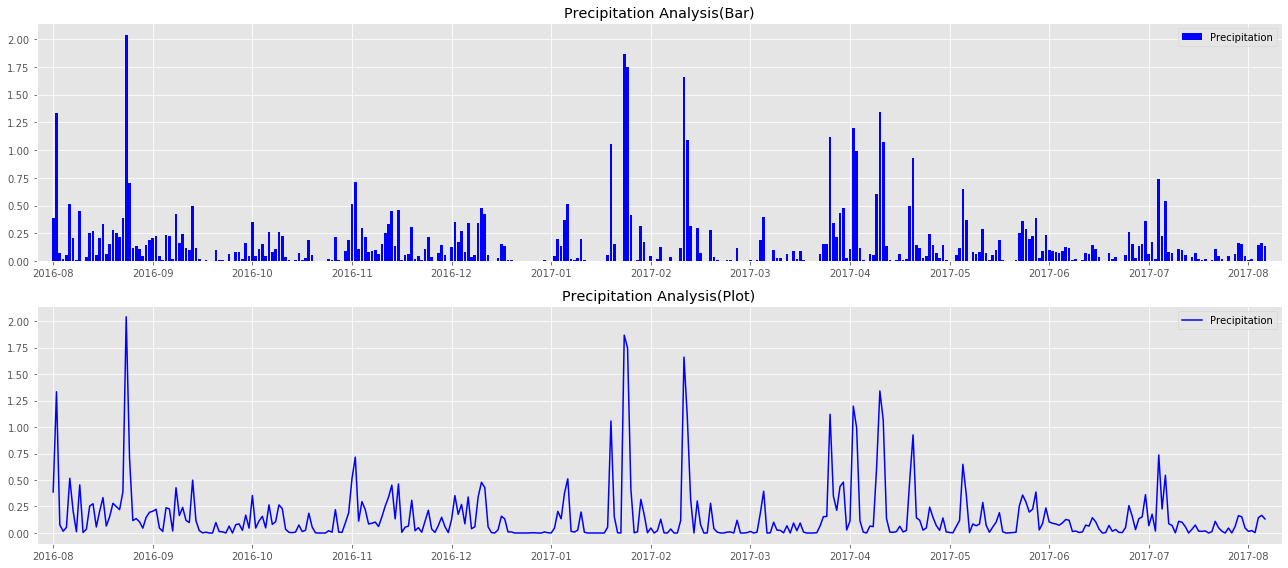

In [21]:

plt.style.use('ggplot')
x_label = ['2016-08', '2016-09', '2016-10', '2016-11', '2016-12', 
          '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', 
          '2017-06', '2017-07', '2017-08', ]
x_value= np.arange(len(prcp_df['date']))
fig, ax = plt.subplots(nrows=2,figsize=(18, 8))
major_ticks = np.arange(0, 390, 30)
ax[0].bar(x_value, prcp_df['precipitation'], color='blue')
ax[0].set_xticks(major_ticks)
ax[0].set_xticklabels(x_label)
ax[0].set_xlim(-5,370)
ax[0].legend(['Precipitation'], loc=0)
ax[0].set_title('Precipitation Analysis(Bar)')
ax[1].plot(x_value, prcp_df['precipitation'], color='blue')
ax[1].set_xticks(major_ticks)
ax[1].set_xticklabels(x_label)
ax[1].set_xlim(-5,370)
ax[1].legend(['Precipitation'], loc=0)
ax[1].set_title('Precipitation Analysis(Plot)')
plt.tight_layout()
plt.savefig("precipitation_analysis.png", bbox_inches='tight')
plt.show()

In [22]:
station = session.query(func.count(Station.station)).all()
station_count = station[0][0]
station_count

9

In [24]:
observation_count = session.query(Station.name, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
observation_count


[('WAIHEE 837.5, HI US', 2772),
 ('WAIKIKI 717.2, HI US', 2724),
 ('KANEOHE 838.1, HI US', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('PEARL CITY, HI US', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 511)]

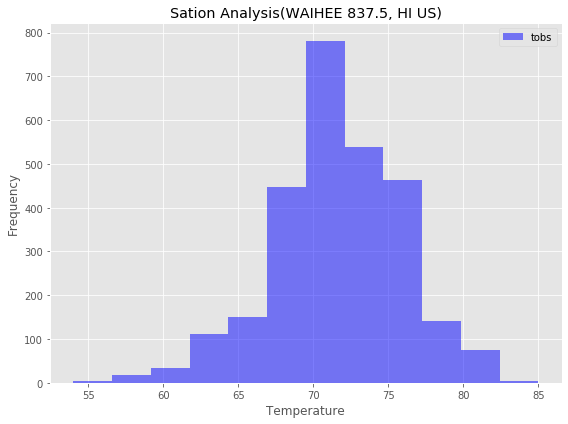

In [25]:
temperature = session.query(Measurement.tobs).\
              filter(Station.station == Measurement.station).\
              filter(Station.name == 'WAIHEE 837.5, HI US').all()
        
tobs_df = pd.DataFrame(temperature, columns=['tobs'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(tobs_df['tobs'], bins=12, color='blue', alpha=0.5)
ax.legend(['tobs'])
ax.set_title('Sation Analysis(WAIHEE 837.5, HI US)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("station_analysis.png", bbox_inches='tight')
plt.show()

In [26]:
def calc_temps(start_date, end_date):
    min_temp = session.query(func.min(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    max_temp = session.query(func.max(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    result = min_temp, max_temp, avg_temp
    return list(np.ravel(result))

In [34]:
def calc_temps(start, end):
    """ function calc_temps
        parameters: start (string), end (string)
        returns: list
        extracts data using a SQL Alchemy query and returns list
        of avg temperature, lowest temperature, highest temperature
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
    return temp_list

In [35]:
def get_prev_year_date(target):
    """ function get_prev_year_date
        parameters: target (string)
        returns: string
        disassembles string and subtracts 1 from year portion
        returns parameter input on error
    """
    try:
        xl = target.split('-')
        xc = (str(int(xl[0])-1)) + '-' + xl[1] + '-' + xl[2]
        return xc
    except:
        return target




In [37]:
trip_start_date = '2016-08-01'
trip_end_date = '2017-08-01'

In [38]:
start_conv = get_prev_year_date(trip_start_date)
end_conv = get_prev_year_date(trip_end_date)

In [39]:
temp_list = calc_temps(start_conv, end_conv)

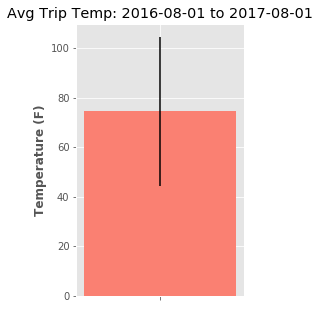

In [44]:

plt.figure(figsize=(3,5))                                                    # plots data
plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='salmon')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Avg Trip Temp: %s to %s" % ("2016-08-01", "2017-08-01"))
plt.show()